In [1]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # Select the GPU index
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.init import xavier_uniform_
from torch.nn.init import constant_
from torch.nn.init import xavier_normal_
from torch.utils.data import Dataset, DataLoader
import math
from PIL import Image
from collections import OrderedDict
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
from torch.optim.lr_scheduler import _LRScheduler
import warnings
import spacy
from scipy.io import savemat
import dill as pickle
import thop
from typing import Optional, Tuple, Any
from typing import List, Optional, Tuple
from torch_challenge_dataset import DeepVerseChallengeLoaderTaskTwo
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
Tensor = torch.Tensor

In [3]:
#Parameters
onoffdict={'GPS': False, 'CAMERAS': False, 'RADAR': False}
lr=1e-4
num_epochs=200
#encoding_features=1024 #keep it in power of 2
reduction = 4
batch_size = 200
weight_path=f'models0/Transnettask2/cr{reduction}/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'

In [4]:
reduction

4

In [5]:
weight_path

'models0/Transnettask2/cr4/gpsFalse_camFalse_radFalse/'

In [6]:
if not os.path.exists(weight_path):
    os.makedirs(weight_path)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Analysis

In [8]:
train_dataset = DeepVerseChallengeLoaderTaskTwo(csv_path = r'./dataset_train.csv')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=5)
test_dataset = DeepVerseChallengeLoaderTaskTwo(csv_path = r'./dataset_validation.csv')
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, num_workers=5)

In [9]:
def CSI_reshape( y, csi_std=2.5e-06, target_std=1):
        ry = torch.real(y)
        iy= torch.imag(y)
        oy=torch.cat([ry,iy],dim=1)
        #scaling
        oy=(oy/csi_std)*target_std
        return oy

# Utils and Models

In [10]:
def CSI_reshape( y, csi_std=2.5e-06, target_std=1):
        ry = torch.real(y)
        iy= torch.imag(y)
        oy=torch.cat([ry,iy],dim=1)
        #scaling
        oy=(oy/csi_std)*target_std
        return oy

In [11]:
def CSI_ri_avg(y):
    ry=y[:,0,:,:]
    iy=y[:,1,:,:]
    y = torch.sqrt(ry**2+iy**2)
    return y

In [12]:
def cal_model_parameters(model):
    total_param  = []
    for p1 in model.parameters():
        total_param.append(int(p1.numel()))
    return sum(total_param)

In [13]:
def NMSE_cal(x_hat, x):
    x_real = torch.reshape(torch.real(x), (x.shape[0], -1))
    x_imag = torch.reshape(torch.imag(x), (x.shape[0], -1))
    x_hat_real = torch.reshape(torch.real(x_hat), (x.shape[0], -1))
    x_hat_imag = torch.reshape(torch.imag(x_hat), (x.shape[0], -1))
    power = torch.sum(x_real** 2 + x_imag** 2, dim=1)
    mse = torch.sum((x_real - x_hat_real) ** 2 + (x_imag - x_hat_imag) ** 2, dim=1)
    nmse = torch.mean(mse / power)
    return nmse

In [14]:
def scale_dot_attention(
       q:Tensor,
       k:Tensor,
       v:Tensor,
       dropout_p:float = 0.0,
       attn_mask : Optional[Tensor] = None,
)-> Tuple[Tensor,Tensor]:
    
    _,_,E = q.shape
    q = q / math.sqrt(E)
    attn = torch.bmm(q,k.transpose(-2,-1))
    if attn_mask is not None:
        attn = attn + attn_mask
    attn = F.softmax(attn,dim =-1)
    if dropout_p:
        attn = F.dropout(attn,p = dropout_p)
    out = torch.bmm(attn,v)

    return out,attn


In [15]:
def multi_head_attention_forward(
        query: Tensor,
        key: Tensor,
        value: Tensor,
        num_heads: int,
        in_proj_weight: Tensor,
        in_proj_bias: Optional[Tensor],
        dropout_p: float,
        out_proj_weight: Tensor,
        out_proj_bias: Optional[Tensor],
        training: bool = True,
        key_padding_mask: Optional[Tensor] = None,
        need_weights: bool = True,
        attn_mask: Optional[Tensor] = None,
        use_separate_proj_weight=None,
        q_proj_weight: Optional[Tensor] = None,
        k_proj_weight: Optional[Tensor] = None,
        v_proj_weight: Optional[Tensor] = None,
) -> Tuple[Tensor, Optional[Tensor]]:
    
    tgt_len, bsz, embed_dim = query.shape
    src_len, _, _ = key.shape
    head_dim = embed_dim // num_heads
    q, k, v = _in_projection_packed(query, key, value, in_proj_weight, in_proj_bias)
    
    if attn_mask is not None:
        if attn_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            attn_mask = attn_mask.to(torch.bool)
        else:
            assert attn_mask.is_floating_point() or attn_mask.dtype == torch.bool, \
                f"Only float, byte, and bool types are supported for attn_mask, not {attn_mask.dtype}"

        if attn_mask.dim() == 2:
            correct_2d_size = (tgt_len, src_len)
            if attn_mask.shape != correct_2d_size:
                raise RuntimeError(
                    f"The shape of the 2D attn_mask is {attn_mask.shape}, but should be {correct_2d_size}.")
            attn_mask = attn_mask.unsqueeze(0)
        elif attn_mask.dim() == 3:
            correct_3d_size = (bsz * num_heads, tgt_len, src_len)
            if attn_mask.shape != correct_3d_size:
                raise RuntimeError(
                    f"The shape of the 3D attn_mask is {attn_mask.shape}, but should be {correct_3d_size}.")
        else:
            raise RuntimeError(f"attn_mask's dimension {attn_mask.dim()} is not supported")

    if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
        warnings.warn(
            "Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
        key_padding_mask = key_padding_mask.to(torch.bool)


    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    
    if key_padding_mask is not None:
        assert key_padding_mask.shape == (bsz, src_len), \
            f"expecting key_padding_mask shape of {(bsz, src_len)}, but got {key_padding_mask.shape}"
        key_padding_mask = key_padding_mask.view(bsz, 1, 1, src_len). \
            expand(-1, num_heads, -1, -1).reshape(bsz * num_heads, 1, src_len)
        if attn_mask is None:
            attn_mask = key_padding_mask
        elif attn_mask.dtype == torch.bool:
            attn_mask = attn_mask.logical_or(key_padding_mask)
        else:
            attn_mask = attn_mask.masked_fill(key_padding_mask, float("-inf"))
  
    if attn_mask is not None and attn_mask.dtype == torch.bool:
        new_attn_mask = torch.zeros_like(attn_mask, dtype=torch.float)
        new_attn_mask.masked_fill_(attn_mask, float("-inf"))
        attn_mask = new_attn_mask

    
    if not training:
        dropout_p = 0.0
    attn_output, attn_output_weights = scale_dot_attention(q, k, v, attn_mask, dropout_p)
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output = nn.functional.linear(attn_output, out_proj_weight, out_proj_bias)
    if need_weights:
        # average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        return attn_output, attn_output_weights.sum(dim=1) / num_heads
    else:
        return attn_output, None

In [16]:
def _in_projection_packed(
    q: Tensor,
    k: Tensor,
    v: Tensor,
    w: Tensor,
    b: Optional[Tensor] = None,
) -> List[Tensor]:
    E = q.size(-1)
    if k is v:
        if q is k:
            return F.linear(q, w, b).chunk(3, dim=-1)
        else:
            w_q, w_kv = w.split([E, E * 2])
            if b is None:
                b_q = b_kv = None
            else:
                b_q, b_kv = b.split([E, E * 2])
            return (F.linear(q, w_q, b_q),) + F.linear(k, w_kv, b_kv).chunk(2, dim=-1)
    else:
        w_q, w_k, w_v = w.chunk(3)
        if b is None:
            b_q = b_k = b_v = None
        else:
            b_q, b_k, b_v = b.chunk(3)
        return F.linear(q, w_q, b_q), F.linear(k, w_k, b_k), F.linear(v, w_v, b_v)

In [17]:
class MultiheadAttention(nn.Module):

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True,
                 kdim=None, vdim=None, batch_first=False) -> None:
        # factory_kwargs = {'device': device, 'dtype': dtype}
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == self.embed_dim and self.vdim == self.embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_first = batch_first
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        if self._qkv_same_embed_dim is False:
            self.q_proj_weight = Parameter(torch.empty((embed_dim, embed_dim)))
            self.k_proj_weight = Parameter(torch.empty((embed_dim, self.kdim)))
            self.v_proj_weight = Parameter(torch.empty((embed_dim, self.vdim)))
            self.register_parameter('in_proj_weight', None)
        else:
            self.in_proj_weight = Parameter(torch.empty((3 * embed_dim,embed_dim)))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)

        if bias:
            self.in_proj_bias = Parameter(torch.empty(3 * embed_dim))
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

        self._reset_parameters()
        
    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            xavier_uniform_(self.in_proj_weight)
        else:
            xavier_uniform_(self.q_proj_weight)
            xavier_uniform_(self.k_proj_weight)
            xavier_uniform_(self.v_proj_weight)

        if self.in_proj_bias is not None:
            constant_(self.in_proj_bias, 0.)
            constant_(self.out_proj.bias, 0.)



    def forward(self, query: Tensor, key: Tensor, value: Tensor, key_padding_mask: Optional[Tensor] = None,
                need_weights: bool = True, attn_mask: Optional[Tensor] = None) -> Tuple[Tensor, Optional[Tensor]]:
        if self.batch_first:
            query, key, value = [x.transpose(1, 0) for x in (query, key, value)]

        if not self._qkv_same_embed_dim:
            attn_output, attn_output_weights = multi_head_attention_forward(
                query, key, value, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight)
        else:
            attn_output, attn_output_weights = multi_head_attention_forward(
                query, key, value, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask)
            
        if self.batch_first:
            return attn_output.transpose(1, 0), attn_output_weights
        else:
            return attn_output, attn_output_weights

In [18]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=F.relu,
                 layer_norm_eps=1e-5, batch_first=False) -> None:
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model,nhead,
                                            dropout=dropout, batch_first=batch_first)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout(src2)
        src = self.norm2(src)
        return src

In [19]:
class TransformerEncoder(nn.Module):

    def __init__(self, encoder_layer, num_layers, norm=None):
        super(TransformerEncoder, self).__init__()
        self.layer = encoder_layer
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src: Tensor, mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        output = src
        for _ in range(self.num_layers):
            output = self.layer(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output

In [20]:
#Decoder Layer:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=F.relu,
                 layer_norm_eps=1e-5, batch_first=False) -> None:
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model,nhead,
                                            dropout=dropout, batch_first=batch_first)
        self.multihead_attn = MultiheadAttention(d_model,nhead,dropout=dropout, batch_first=batch_first)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm3 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = activation

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        tgt2 = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

In [21]:
#Decoder
class TransformerDecoder(nn.Module):
    
    def __init__(self, decoder_layer, num_layers, norm=None):
        super(TransformerDecoder, self).__init__()
        self.layer = decoder_layer
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        output = tgt
        for _ in range(self.num_layers):
            output = self.layer(output, memory, tgt_mask=tgt_mask,
                                memory_mask=memory_mask,
                                tgt_key_padding_mask=tgt_key_padding_mask,
                                memory_key_padding_mask=memory_key_padding_mask)
        if self.norm is not None:
            output = self.norm(output)

        return output


In [22]:
class task2Encoder(nn.Module):
    
    def __init__(self,  d_model: int = 64, nhead: int = 8, num_encoder_layers: int = 6,
                 num_decoder_layers: int = 6, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation = F.relu, custom_encoder: Optional[Any] = None, custom_decoder: Optional[Any] = None,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False,  reduction=64) -> None:
        super(task2Encoder, self).__init__()
        self.total_size =8192
       
        if custom_encoder is not None:
            self.encoder = custom_encoder
        else:
            encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout,
                                                    activation, layer_norm_eps, batch_first)
            encoder_norm = nn.LayerNorm(d_model, eps=layer_norm_eps)
            self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers)
       
        self.d_model = d_model
        
        assert not (self.total_size % self.d_model), 'd_model needs to be divisible by the size of the entire csi matrix (2048)'
        self.feature_shape = (self.total_size//self.d_model, self.d_model)

        self.nhead = nhead

        self.batch_first = batch_first
        self.fc_encoder = nn.Linear(self.total_size,self.total_size//reduction)
        #self.fc_decoder = nn.Linear(self.total_size//reduction,self.total_size)
        self._reset_parameters()

                
        
    def forward(self, src: Tensor, tgt: Optional[Tensor]=None, src_mask: Optional[Tensor] = None,
                    tgt_mask: Optional[Tensor] = None,
                    memory_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None,
                    tgt_key_padding_mask: Optional[Tensor] = None,
                    memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        
        memory = self.encoder(src.view(-1, self.feature_shape[0], self.feature_shape[1]), mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        memory_encoder = self.fc_encoder(memory.view(memory.shape[0],-1))
        
        return memory_encoder
    def generate_square_subsequent_mask(self, sz: int) -> Tensor:
        
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)

        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def _reset_parameters(self):
   
        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)  

In [23]:
class task2Decoder(nn.Module):
    
    def __init__(self,  d_model: int = 64, nhead: int = 8, num_encoder_layers: int = 6,
                 num_decoder_layers: int = 6, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation = F.relu, custom_encoder: Optional[Any] = None, custom_decoder: Optional[Any] = None,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False,  reduction=64) -> None:
        super(task2Decoder, self).__init__()
        self.total_size = 8192
        w, h =64, 64
        if custom_decoder is not None:
            self.decoder = custom_decoder
        else:
            decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout,
                                                    activation, layer_norm_eps, batch_first)
            decoder_norm = nn.LayerNorm(d_model, eps=layer_norm_eps)
            self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)
        
        self.d_model = d_model
        
        assert not (self.total_size % self.d_model), 'd_model needs to be divisible by the size of the entire csi matrix (2048)'
        self.feature_shape = (self.total_size//self.d_model, self.d_model)

        self.nhead = nhead

        self.batch_first = batch_first
        #self.fc_encoder = nn.Linear(self.total_size,self.total_size//reduction)
        self.fc_decoder = nn.Linear(self.total_size//reduction,self.total_size)
        self._reset_parameters()
        
        
        
    
    def forward(self, memory_encoder, tgt: Optional[Tensor]=None, src_mask: Optional[Tensor] = None,
                    tgt_mask: Optional[Tensor] = None,
                    memory_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None,
                    tgt_key_padding_mask: Optional[Tensor] = None,
                    memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        bs = memory_encoder.size(0)
        
        # Generate final output
        memory_decoder = self.fc_decoder(memory_encoder).view(-1, self.feature_shape[0], self.feature_shape[1])
        output = self.decoder(memory_decoder, memory_decoder, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        output = output.view(-1,2,64,64)
        
        return output
    
    def generate_square_subsequent_mask(self, sz: int) -> Tensor:
        
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)

        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def _reset_parameters(self):
   
        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

In [24]:
#complete task 2 model including encoder, decoder and channel
class task2model(nn.Module):
    def __init__(self, reduction=16):
        super().__init__()
        
        self.en=task2Encoder(d_model=32, num_encoder_layers=2, num_decoder_layers=2, nhead=2, reduction =reduction, dropout= 0.)
        
        self.de=task2Decoder(d_model=32, num_encoder_layers=2, num_decoder_layers=2, nhead=2, reduction =reduction, dropout= 0.)
        
    
   
    def forward(self, Hin, device, is_training): 
        
        #Encoder
        Hencoded=self.en(Hin)
        
        
        #Decoder   
        Hdecoded=self.de(Hencoded)
        

        return Hdecoded

In [25]:
model=task2model(reduction)
print(f'Number of parameters in Task2 Encoder: {cal_model_parameters(model.en)}')
print(f'Number of parameters in Task2 Decoder: {cal_model_parameters(model.de)}')

Number of parameters in Task2 Encoder: 16916768
Number of parameters in Task2 Decoder: 16927264


In [26]:
# Training

In [27]:
#Loss

#criterion=nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
criterion= nn.MSELoss().to(device)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#if SGDR == True:
#    sched = CosineWithRestarts(optimizer, T_max=n_batches)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, threshold=0.00001, patience=200, verbose=True)

In [29]:
model=model.to(device)

In [30]:
start_time = time.time()
num_train_batches=len(train_loader)
num_test_batches=len(test_loader)
train_losses = []
val_losses = []

patience_counter = 0
best_val_loss = float('inf')

for i in range(num_epochs):
    loss1 = 0
    
    epoch_time = time.time()
    model.train()
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):  
        optimizer.zero_grad()
        y_train=y_train.to(device)
        # Apply the model
        Xin = CSI_reshape(X_train[0])
        y_pred=model(Xin.to(device), device, is_training=True)
        y_train_reshaped=CSI_reshape(y_train)
        loss = criterion(y_pred, y_train_reshaped) 
        # Update parameters
        loss.backward()
        optimizer.step()
        loss1=loss1+loss
        
            
    train_loss=loss1/num_train_batches  
    train_losses.append(train_loss.item())
    
    
   
    # Run the testing batches
    model.eval()
    with torch.no_grad():
        loss1=0 
        nmse1=0
        for b, (X_test, y_test) in enumerate(test_loader):
            y_test=y_test.to(device)
            # Apply the model
            Xin = CSI_reshape(X_test[0])
            y_pred=model(Xin.to(device), device, is_training=True)
            y_test_reshaped=CSI_reshape(y_test)
            loss = criterion(y_pred, y_test_reshaped) 
            loss1=loss1+loss  
            
        val_loss=loss1/num_test_batches 
        
        val_losses.append(val_loss.item())
    print(f'epoch:{i+1}/{num_epochs} average reshaped TL:{train_loss.item():10.8f} average reshaped VL:{val_loss.item():10.8f} epoch time:{time.time() - epoch_time:.0f} seconds, lr:{optimizer.param_groups[0]["lr"]:.2e}')               
        # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, weight_path+"task2.pth")
        torch.save(model.en, weight_path+"task2Encoder.pth")
        torch.save(model.de, weight_path+"task2Decoder.pth")

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:1/200 average reshaped TL:1.66170228 average reshaped VL:1.45468676 epoch time:395 seconds, lr:1.00e-04
epoch:2/200 average reshaped TL:1.28195071 average reshaped VL:1.33440971 epoch time:498 seconds, lr:1.00e-04
epoch:3/200 average reshaped TL:1.19061363 average reshaped VL:1.29364502 epoch time:498 seconds, lr:1.00e-04
epoch:4/200 average reshaped TL:1.14608884 average reshaped VL:1.22427261 epoch time:467 seconds, lr:1.00e-04
epoch:5/200 average reshaped TL:1.11325085 average reshaped VL:1.21687019 epoch time:485 seconds, lr:1.00e-04
epoch:6/200 average reshaped TL:1.08656740 average reshaped VL:1.24812150 epoch time:481 seconds, lr:1.00e-04
epoch:7/200 average reshaped TL:1.06377172 average reshaped VL:1.16575444 epoch time:466 seconds, lr:1.00e-04
epoch:8/200 average reshaped TL:1.04338217 average reshaped VL:1.17649865 epoch time:465 seconds, lr:1.00e-04
epoch:9/200 average reshaped TL:1.02443433 average reshaped VL:1.16272581 epoch time:472 seconds, lr:1.00e-04
epoch:10/2

epoch:75/200 average reshaped TL:0.59994757 average reshaped VL:0.82636893 epoch time:477 seconds, lr:1.00e-04
epoch:76/200 average reshaped TL:0.59829849 average reshaped VL:0.84399772 epoch time:485 seconds, lr:1.00e-04
epoch:77/200 average reshaped TL:0.59652919 average reshaped VL:0.84290230 epoch time:492 seconds, lr:1.00e-04
epoch:78/200 average reshaped TL:0.59469533 average reshaped VL:0.82522243 epoch time:516 seconds, lr:1.00e-04
epoch:79/200 average reshaped TL:0.59294927 average reshaped VL:0.81295788 epoch time:512 seconds, lr:1.00e-04
epoch:80/200 average reshaped TL:0.59121192 average reshaped VL:0.81538588 epoch time:505 seconds, lr:1.00e-04
epoch:81/200 average reshaped TL:0.58938575 average reshaped VL:0.83516037 epoch time:516 seconds, lr:1.00e-04
epoch:82/200 average reshaped TL:0.58765167 average reshaped VL:0.82236981 epoch time:506 seconds, lr:1.00e-04
epoch:83/200 average reshaped TL:0.58581424 average reshaped VL:0.83357340 epoch time:481 seconds, lr:1.00e-04
e

epoch:149/200 average reshaped TL:0.47209239 average reshaped VL:0.80071330 epoch time:350 seconds, lr:1.00e-04
epoch:150/200 average reshaped TL:0.47049221 average reshaped VL:0.78522152 epoch time:345 seconds, lr:1.00e-04
epoch:151/200 average reshaped TL:0.46894273 average reshaped VL:0.78956938 epoch time:330 seconds, lr:1.00e-04
epoch:152/200 average reshaped TL:0.46752423 average reshaped VL:0.79170316 epoch time:332 seconds, lr:1.00e-04
epoch:153/200 average reshaped TL:0.46596372 average reshaped VL:0.82038325 epoch time:331 seconds, lr:1.00e-04
epoch:154/200 average reshaped TL:0.46451870 average reshaped VL:0.79492021 epoch time:334 seconds, lr:1.00e-04
epoch:155/200 average reshaped TL:0.46302515 average reshaped VL:0.80367076 epoch time:335 seconds, lr:1.00e-04
epoch:156/200 average reshaped TL:0.46154025 average reshaped VL:0.79356885 epoch time:332 seconds, lr:1.00e-04
epoch:157/200 average reshaped TL:0.46015465 average reshaped VL:0.78656077 epoch time:335 seconds, lr:1

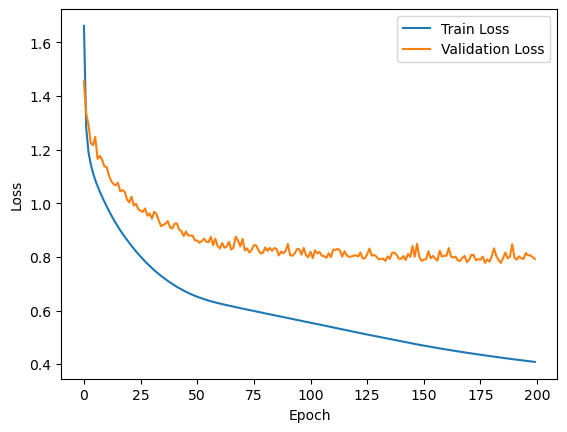

In [31]:
# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
flops, params = thop.profile(model, inputs=(Xin.to(device), device, True, ), verbose=False)
print(f'Model Flops: {flops}')
print(f'Model Params Num: {params}\n')

Model Flops: 16813260800.0
Model Params Num: 33831360.0



In [33]:
np.save(weight_path+'train_loss.npy', train_losses)
np.save(weight_path+'val_loss.npy', val_losses)

# Inference

In [34]:
#Create an instance of your model
#model = task2model()

model2=torch.load(weight_path+"task2.pth").to(device)
# Run the testing batches
model2.eval()
with torch.no_grad():
    mse1=0
    for b, (X_test, y_test) in enumerate(test_loader):

        y_test=y_test.to(device)
        # Apply the model
        Xin = CSI_reshape(X_test[0])
        y_pred=model2(Xin.to(device), device, is_training=False)
        y_test_reshaped = CSI_reshape(y_test)
        mse0 = criterion(CSI_ri_avg(y_pred), CSI_ri_avg(y_test_reshaped))
        mse1+=mse0 
        
    avg_mse=mse1/num_test_batches

In [35]:
print(f'Average MSE:{avg_mse}')


Average MSE:1.0089222192764282


In [36]:
h_list = torch.tensor([])
for b, (x,h) in enumerate(test_loader):
    h = CSI_ri_avg(CSI_reshape(h))
    h_list = torch.cat([h_list,h])
target_loss = torch.mean((torch.abs(h_list) - torch.mean(torch.abs(h_list))) ** 2)

In [37]:
improvement = (target_loss.item() - avg_mse) / target_loss.item() * 100
print(f'Percentage Improvement Achieved: {improvement:.4f}%')

Percentage Improvement Achieved: 28.5190%


In [38]:
target_loss

tensor(1.4115)